In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [34]:
# Define path to your data
data_dir = 'augmented_data'  # Replace with the path to your data

# Image dimensions
img_width, img_height = 224, 224
batch_size = 32

# Data augmentation and normalization for training
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

# Training data generator
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 608 images belonging to 4 classes.
Found 152 images belonging to 4 classes.


In [30]:
# Load the base model with pretrained weights
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout to prevent overfitting
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Callbacks to prevent overfitting and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20,  # Adjust based on your dataset size
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
19/19 [==============================] - 31s 2s/step - loss: 0.1963 - accuracy: 0.9342 - val_loss: 0.1305 - val_accuracy: 0.9688 - lr: 5.0000e-05
Epoch 2/20
19/19 [==============================] - 28s 1s/step - loss: 0.1745 - accuracy: 0.9474 - val_loss: 0.1742 - val_accuracy: 0.9453 - lr: 5.0000e-05
Epoch 3/20
19/19 [==============================] - 27s 1s/step - loss: 0.1724 - accuracy: 0.9523 - val_loss: 0.1797 - val_accuracy: 0.9531 - lr: 5.0000e-05
Epoch 4/20
19/19 [==============================] - 27s 1s/step - loss: 0.1847 - accuracy: 0.9326 - val_loss: 0.1187 - val_accuracy: 0.9766 - lr: 5.0000e-05
Epoch 5/20
19/19 [==============================] - 27s 1s/step - loss: 0.1729 - accuracy: 0.9490 - val_loss: 0.1439 - val_accuracy: 0.9609 - lr: 5.0000e-05
Epoch 6/20
19/19 [==============================] - 27s 1s/step - loss: 0.1699 - accuracy: 0.9391 - val_loss: 0.1095 - val_accuracy: 0.9688 - lr: 5.0000e-05
Epoch 7/20
19/19 [==============================] - 27s 1s

In [17]:
model.save('mobileNetV2_classification.h5')


C:\Users\arthi\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('mobileNetV2_classification.h5')


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on the full validation data
Y_pred = model.predict(validation_generator, steps=validation_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# True labels from the generator
y_true = validation_generator.classes

# Ensure that y_pred and y_true have the same length
if len(y_pred) > len(y_true):
    y_pred = y_pred[:len(y_true)]
elif len(y_pred) < len(y_true):
    y_true = y_true[:len(y_pred)]

# Class labels
class_labels = list(validation_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))


TypeError: '>' not supported between instances of 'int' and 'DirectoryIterator'

19/19 [==============================] - 5s 217ms/step


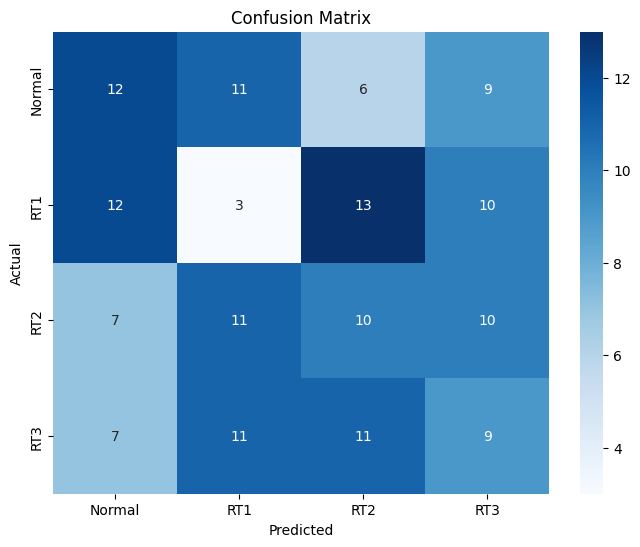

              precision    recall  f1-score   support

      Normal       0.32      0.32      0.32        38
         RT1       0.08      0.08      0.08        38
         RT2       0.25      0.26      0.26        38
         RT3       0.24      0.24      0.24        38

    accuracy                           0.22       152
   macro avg       0.22      0.22      0.22       152
weighted avg       0.22      0.22      0.22       152



In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on the full validation data
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# True labels from the generator
y_true = validation_generator.classes

# Ensure that y_pred and y_true have the same length
if len(y_pred) > len(y_true):
    y_pred = y_pred[:len(y_true)]
elif len(y_pred) < len(y_true):
    y_true = y_true[:len(y_pred)]

# Class labels
class_labels = list(validation_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))


In [20]:
# Calculate accuracy on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')


5/5 [==============================] - 5s 839ms/step - loss: 0.1088 - accuracy: 0.9671
Validation Accuracy: 0.97


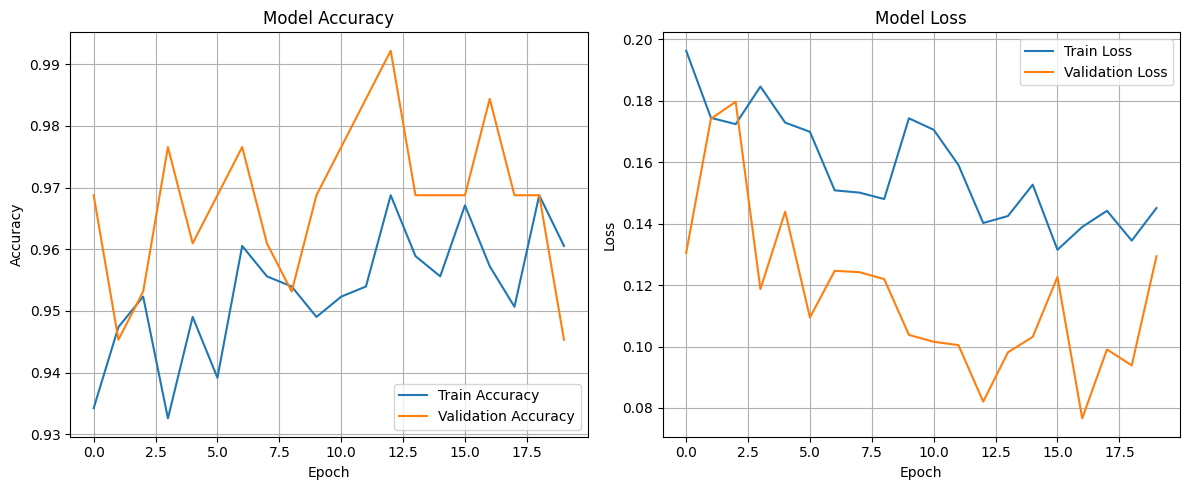

In [21]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# After training the model with your code
plot_accuracy_loss(history)


1/1 [==============================] - 2s 2s/step


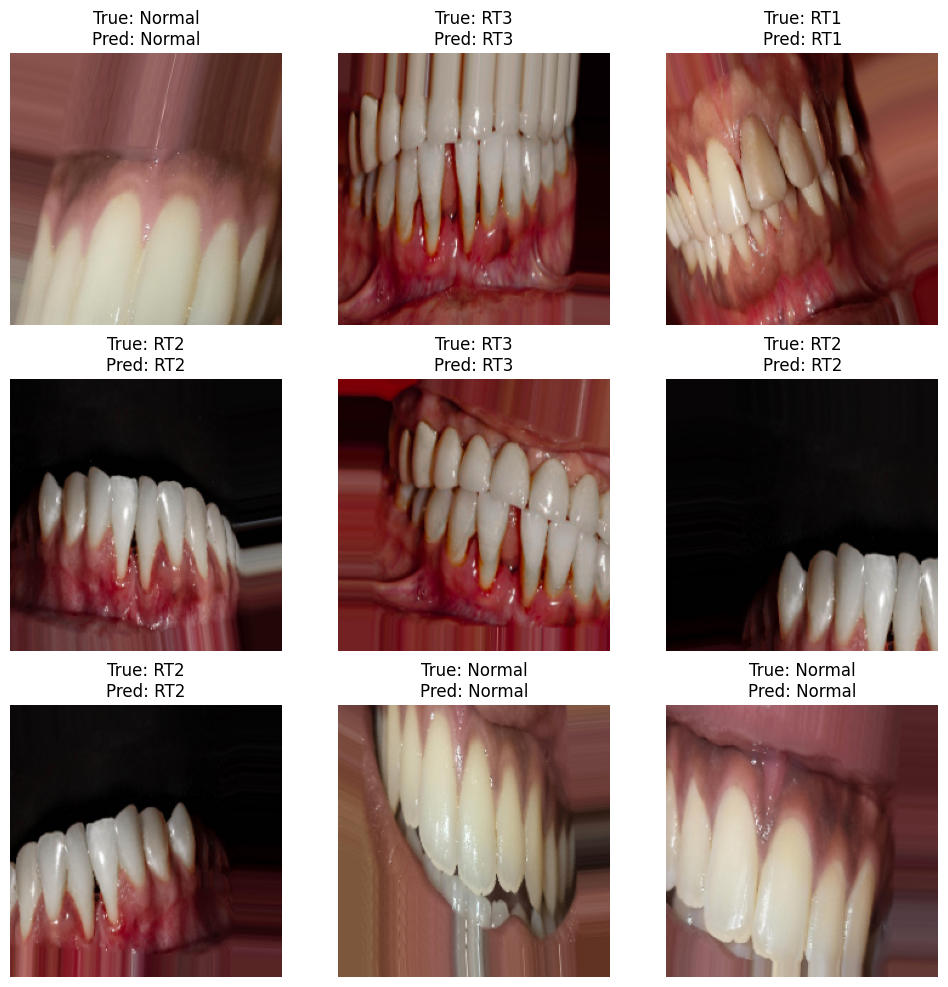

In [22]:
import random

# Get a random batch of images and labels
validation_generator.reset()
x_batch, y_batch = next(validation_generator)
y_pred_batch = model.predict(x_batch)
y_pred_labels = np.argmax(y_pred_batch, axis=1)
y_true_labels = np.argmax(y_batch, axis=1)

# Visualize predictions
plt.figure(figsize=(12, 12))
for i in range(9):  # Displaying 9 random images
    idx = random.randint(0, len(y_pred_labels) - 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[idx])
    plt.title(f"True: {class_labels[y_true_labels[idx]]}\nPred: {class_labels[y_pred_labels[idx]]}")
    plt.axis('off')
plt.show()


In [23]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a single test image
img_path = "D:/gingitival recession/augmented_data/RT3/aug_0_9200.jpeg"  # Replace with your image path
img = image.load_img(img_path, target_size=(img_width, img_height))  # Ensure the size matches your model's input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
img_array = img_array / 255.0  # Rescale like the training data

# Predict the class
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)
predicted_class_label = validation_generator.class_indices.keys()

# Output the result
print(f'Predicted class index: {predicted_class_index[0]}')
print(f'Predicted class label: {list(predicted_class_label)[predicted_class_index[0]]}')


1/1 [==============================] - 1s 615ms/step
Predicted class index: 3
Predicted class label: RT3
